In [1]:
pip install pytesseract opencv-python

In [2]:
!apt-get install tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (11.9 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123589 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [4]:
import os
import pytesseract
import cv2
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


# Path to the folder containing BSL sign images on Google Drive
folder_path = '/content/drive/My Drive/BSL_SIGNS'

# Initialize an empty list to store image paths and their corresponding captions
data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Full path to the image file
        img_path = os.path.join(folder_path, filename)

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Use pytesseract to extract text from the image
        caption = pytesseract.image_to_string(img)

        # Append the image path and caption to the list
        data.append((img_path, caption.strip()))


Mounted at /content/drive


In [5]:
# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['image_path', 'caption'])

# Save the DataFrame to a CSV file in Google Drive
df.to_csv('/content/drive/My Drive/bsl_signs_dataset.csv', index=False)

print('Captions extracted and dataset saved to bsl_signs_dataset.csv')

Captions extracted and dataset saved to bsl_signs_dataset.csv


Organize and Preprocess the Data

Now that DATA have extracted the captions and organized the data, we can proceed with preprocessing.

Preprocess the Data

In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/bsl_signs_dataset.csv')

# Ensure all values in 'caption' are strings and fill any missing values
df['caption'] = df['caption'].astype(str).fillna('')

# Define a function to preprocess images
def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize the image
    return img

# Preprocess all images
images = np.array([preprocess_image(img_path) for img_path in df['image_path']])

# Preprocess captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['caption'])
sequences = tokenizer.texts_to_sequences(df['caption'])
max_length = max(len(seq) for seq in sequences)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, sequences, test_size=0.2, random_state=42)

# Pad the sequences
y_train = pad_sequences(y_train, maxlen=max_length, padding='post')
y_test = pad_sequences(y_test, maxlen=max_length, padding='post')

# Define the correct labels
labels_train = np.array([seq[-1] for seq in y_train])
labels_test = np.array([seq[-1] for seq in y_test])

# Remove the last element from each sequence in y_train and y_test
y_train = np.array([seq[:-1] for seq in y_train])
y_test = np.array([seq[:-1] for seq in y_test])

***Develop and Train the Mode***

In [20]:

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, Bidirectional, Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the CNN model for image processing
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu')
])

# Define the LSTM model for caption processing
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256

caption_input = Input(shape=(max_length-1,))
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length-1)(caption_input)
lstm_output = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
lstm_output = Bidirectional(LSTM(256))(lstm_output)

# Combine the two models
combined = Concatenate()([cnn_model.output, lstm_output])
combined_output = Dense(vocab_size, activation='softmax')(combined)

# Define the final model
model = Model(inputs=[cnn_model.input, caption_input], outputs=combined_output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train, y_train], labels_train, epochs=10, validation_data=([X_test, y_test], labels_test))

print('Model trained successfully')

Epoch 1/10
6/6 [==============================] - 72s 3s/step - loss: 2.1159 - accuracy: 0.7963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 15s 3s/step - loss: 0.3745 - accuracy: 0.9938 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 16s 3s/step - loss: 0.2604 - accuracy: 0.9938 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 16s 3s/step - loss: 0.1609 - accuracy: 0.9938 - val_loss: 7.3646e-04 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 16s 3s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.0103e-04 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 15s 3s/step - loss: 1.3115e-04 - accuracy: 1.0000 - val_loss: 3.2971e-06 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 16s 3s/step - loss: 1.4101e-05 - accuracy: 1.0000 - val_loss: 1.3985e-06 - val_accuracy: 1.000

In [22]:
# Save the model
model.save('bsl_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 4s 4s/step


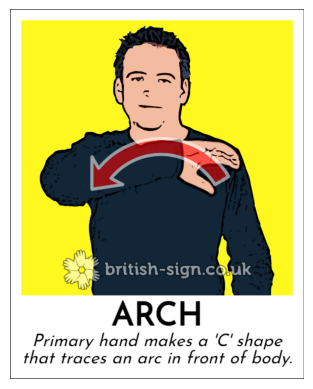

Actual Caption: E british-sign.cay

 

ARCH

Primary hand makes a 'C' shape
that traces an arc in front of body.
2/2 [==============================] - 4s 323ms/step - loss: 8.0248e-07 - accuracy: 1.0000
Test Accuracy: 1.0000
Test Loss: 0.0000


In [28]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('bsl_model.h5')

# Function to display an image with its caption
def display_image_with_caption(img_path, caption):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

# Function to preprocess a single image
def preprocess_single_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize the image
    return img

# Take a random image from the test set
random_index = random.randint(0, len(X_test) - 1)
random_image_path = df.iloc[random_index]['image_path']
random_image = preprocess_single_image(random_image_path)
random_caption = df.iloc[random_index]['caption']

# Predict the caption for the random image
random_image = np.expand_dims(random_image, axis=0)
predicted_caption = model.predict([random_image, np.zeros((1, max_length-1))])
predicted_caption = np.argmax(predicted_caption, axis=-1)

# Convert the predicted sequence of integers to words
predicted_words = [tokenizer.index_word.get(i, '') for i in predicted_caption.flatten()]

# Display the image with the predicted caption and the actual caption
display_image_with_caption(random_image_path, ' '.join(predicted_words))
print(f"Actual Caption: {random_caption}")

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_test, y_test], labels_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
